# Tutorial de MLflow: Introducción práctica a MLOps

En este notebook aprenderemos los conceptos fundamentales de **MLflow**, una plataforma abierta para gestionar el ciclo de vida de los modelos de machine learning.

A lo largo del tutorial realizaremos:
- la configuración del entorno de trabajo
- la carga y preparación de datos
- la ejecución de experimentos con diferentes modelos y parámetros
- el registro de los resultados en MLflow
- y la gestión de modelos entrenados

El objetivo final es entender cómo **estructurar el proceso experimental** y cómo **versionar modelos de ML** de forma reproducible.


## 1. Configuración del entorno

En esta primera sección se crea el entorno virtual e instalamos las dependencias necesarias.

> 💡 En un entorno local, estas líneas se ejecutan desde la terminal o el símbolo del sistema (`cmd`).  
> En un entorno gestionado (como Databricks o Google Colab), muchas veces ya vienen preinstaladas.

El entorno virtual permite aislar las librerías del proyecto, garantizando reproducibilidad y evitando conflictos entre versiones.

In [ ]:
! python -m venv .venv

Posteriormente, instalamos las librerias necesarias.

In [ ]:
! pip install mlflow scikit-learn pandas

## 1.1. Preparación de los datos

En esta sección se importan las librerías principales y se carga el dataset **Iris** desde scikit-learn.  
También se establece la conexión con el servidor local de MLflow, que actuará como nuestro *tracking server*.

Se definen variables base del proyecto (por ejemplo, `PROJECT_NAME`), que sirven para organizar los experimentos.

Finalmente, se realiza la división en **train/test** para disponer de un conjunto de evaluación independiente.

> Objetivo: dejar listos los datos y la conexión para registrar los experimentos en MLflow.


In [1]:
import mlflow
from mlflow import MlflowClient
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, log_loss
)
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import json
import pandas as pd

In [2]:
# Conectamos al servidor local de MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")    # Chequea la URI de tu servidor MLflow

client = MlflowClient(tracking_uri="http://127.0.0.1:5000")
PROJECT_NAME = "mlflow_tutorial"

In [3]:
iris = load_iris(as_frame=True)
X = iris.data.copy()         # DataFrame
y = iris.target.to_frame(name="target")  # DataFrame

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Matplotlib is building the font cache; this may take a moment.


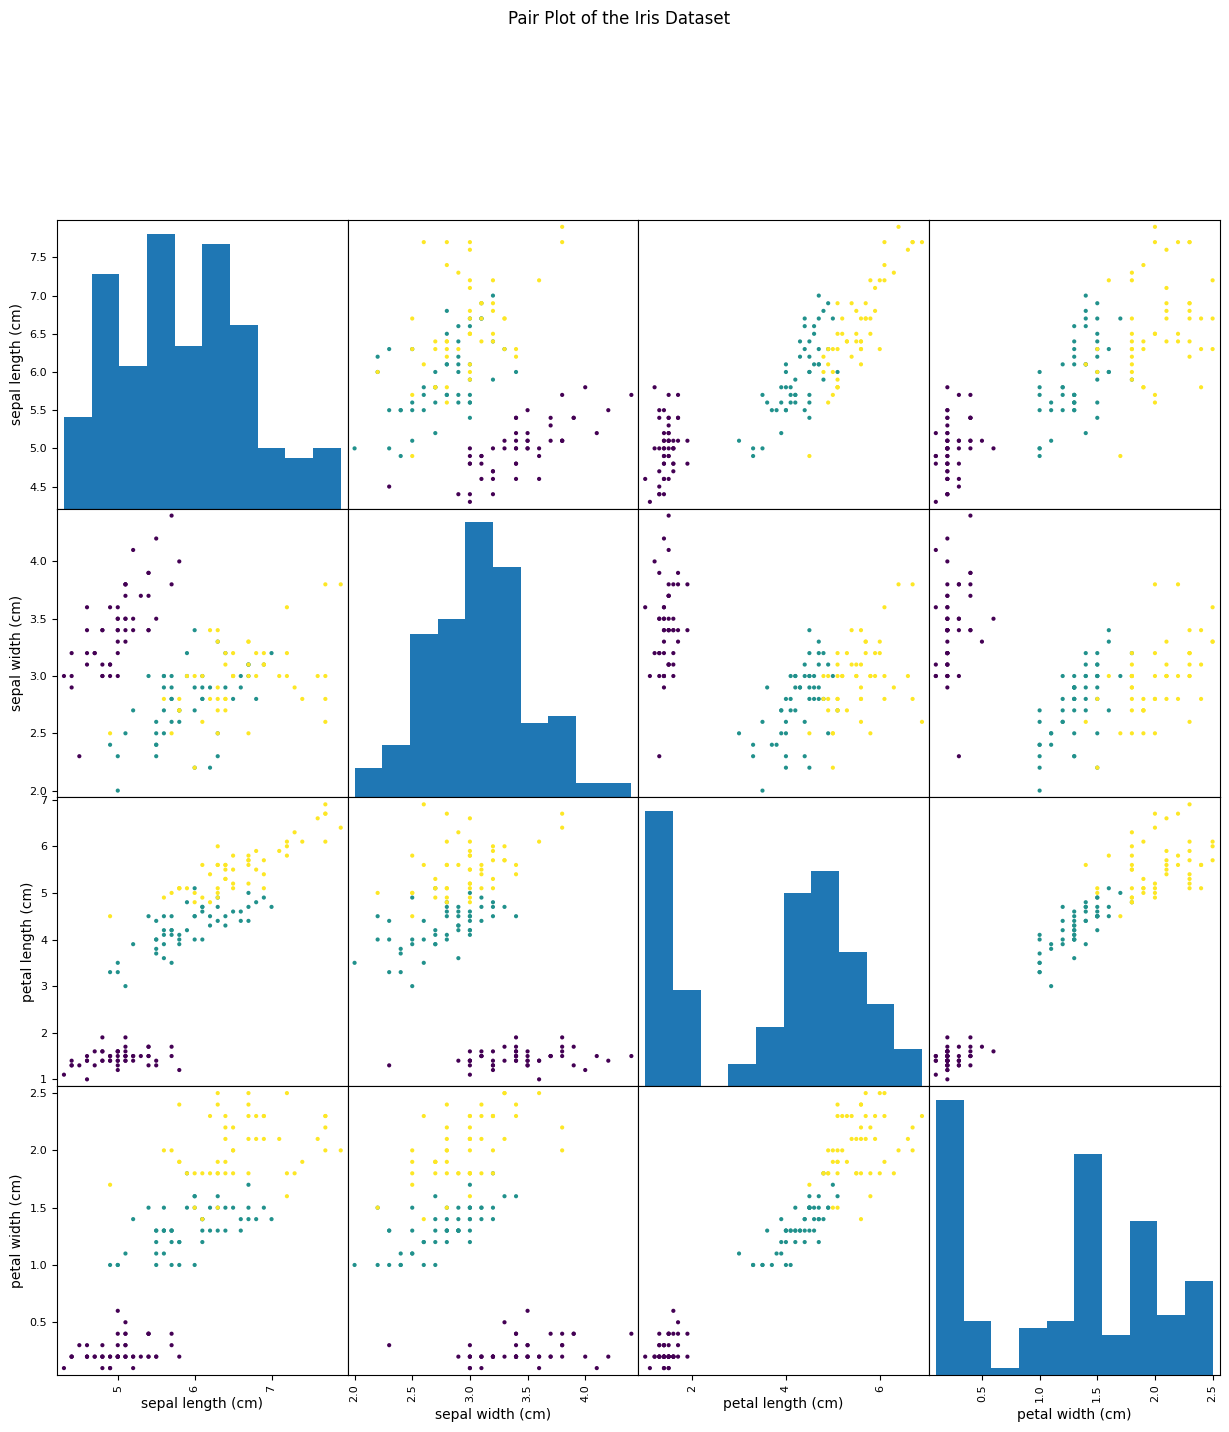

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
pd.plotting.register_matplotlib_converters()

# Load the iris dataset
iris = load_iris(as_frame=True)
df = iris.frame

# Add target labels as names
df["species"] = df["target"].map(dict(zip(range(3), iris.target_names)))

# Create a pair plot using pandas
pd.plotting.scatter_matrix(
    df.drop(columns="target"),
    c=df["target"],
    figsize=(15, 15),
    diagonal="hist",
    alpha=1,
)
plt.suptitle("Pair Plot of the Iris Dataset", y=1.02)
plt.show()

# 2. Ejecución y registro de experimentos

En esta parte se define la lógica para entrenar modelos y registrar los resultados en MLflow.  
Cada experimento contendrá:
- los parámetros utilizados (por ejemplo, hiperparámetros del modelo),
- las métricas obtenidas (accuracy, f1-score, etc.),
- los artefactos asociados (modelo entrenado, gráficos, etc.).

Esto permite **comparar fácilmente diferentes configuraciones** y elegir la mejor de forma trazable.

## 2.1. Definición de funciones auxiliares

Aquí se crean funciones reutilizables que facilitan el registro automático en MLflow.

Por ejemplo:
- una función que entrena el modelo,
- otra que registra los parámetros y métricas en MLflow,
- y posiblemente otra que guarda el modelo como artefacto.

> Estas funciones son el corazón del flujo MLOps: permiten sistematizar el entrenamiento y registro, garantizando consistencia entre ejecuciones.

In [5]:
def log_metrics_and_params(model, X_test, y_test, extra_params=None):
    """Calcula métricas comunes y las loguea a MLflow."""

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Accuracy y F1
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    # ROC AUC
    n_classes = len(np.unique(y_test))
    if n_classes == 2:
        roc_auc = roc_auc_score(y_test, y_prob[:,1])
    else:
        roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")

    # Log loss
    loss = log_loss(y_test, y_prob)

    # Log metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_macro", f1)
    mlflow.log_metric("roc_auc_ovr", roc_auc)
    mlflow.log_metric("log_loss", loss)

    # Log hyperparameters
    for k, v in model.get_params().items():
        mlflow.log_param(k, v)

    # Extra params
    if extra_params:
        for k,v in extra_params.items():
            mlflow.log_param(k, v)

    print(f"Métricas loggeadas → acc={acc:.3f}, f1={f1:.3f}, auc={roc_auc:.3f}, logloss={loss:.3f}")


In [6]:
def log_dataset_metadata(X_train, X_test, y_train, dataset_version="V1"):
    """Log dataset metadata + y_train info as JSON artifact and dataset version as tag."""
    # Convert y_train to Series
    y_series = y_train.iloc[:, 0] if isinstance(y_train, pd.DataFrame) else y_train

    # Convert all values to native Python types
    class_distribution = {int(k): int(v) for k, v in y_series.value_counts().items()}

    dataset_metadata = {
        "dataset_version": str(dataset_version),
        "num_features": int(X_train.shape[1]),
        "num_samples": int(X_train.shape[0] + X_test.shape[0]),
        "train_size": int(X_train.shape[0]),
        "test_size": int(X_test.shape[0]),
        "feature_names": [str(f) for f in X_train.columns],
        "num_classes": int(len(np.unique(y_train))),
        "class_distribution_train": class_distribution
    }

    # Save artifact JSON
    with open("dataset_metadata.json", "w") as f:
        json.dump(dataset_metadata, f, indent=4)
    mlflow.log_artifact("dataset_metadata.json")

    # Log dataset version as tag (appears in MLflow UI)
    mlflow.set_tag("dataset", str(dataset_version))

## 2.2. Entrenamiento y registro de experimentos

En esta sección se ejecutan múltiples corridas (runs) variando los hiperparámetros del modelo (por ejemplo, la regularización o el solver de la regresión logística).

Cada *run* queda almacenado en el servidor de MLflow, con su:
- código de referencia,
- parámetros,
- métricas,
- y resultados.

Esto permite luego **comparar modelos en la interfaz de MLflow** y analizar su rendimiento.

In [7]:
# Create or get experiment
EXPERIMENT_NAME = "mlflow_tutorial"
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    exp_id = client.create_experiment(EXPERIMENT_NAME)
    print(f"Created experiment '{EXPERIMENT_NAME}' (id={exp_id})")
else:
    exp_id = experiment.experiment_id
    print(f" Using existing experiment '{EXPERIMENT_NAME}' (id={exp_id})")

Created experiment 'mlflow_tutorial' (id=270026705236039851)


## 2.3. Base model Logistic Regression

In [8]:
with mlflow.start_run(experiment_id=exp_id, run_name="logistica_base"):
    log_dataset_metadata(X_train, X_test, y_train, dataset_version="V1")

    model_base = LogisticRegression(max_iter=500)
    model_base.fit(X_train, y_train)

    log_metrics_and_params(model_base, X_test, y_test)

c:\Users\59899\OneDrive\semestre 4\GGD\.venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Métricas loggeadas → acc=0.967, f1=0.967, auc=1.000, logloss=0.159
🏃 View run logistica_base at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/7c3609fd250649b7b0d22efdb8f21fcd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851


## 2.3. Regularized Logistic Regression with Grid Search

In [9]:
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 3, 5],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)
grid.fit(X_train, y_train.values.ravel())  # 1D array

# Log each grid search run individually
for i, params in enumerate(grid.cv_results_['params']):
    acc_mean = grid.cv_results_['mean_test_score'][i]
    acc_std = grid.cv_results_['std_test_score'][i]

    with mlflow.start_run(experiment_id=exp_id, run_name=f"rf_grid_run_{i+1}"):
        log_dataset_metadata(X_train, X_test, y_train, dataset_version="V1")

        model = RandomForestClassifier(**params, random_state=42)
        model.fit(X_train, y_train)

        extra = {"cv_mean_accuracy": float(acc_mean), "cv_std_accuracy": float(acc_std)}
        log_metrics_and_params(model, X_test, y_test, extra_params=extra)

print("All Random Forest grid search runs logged with dataset metadata V1.")

c:\Users\59899\OneDrive\semestre 4\GGD\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Métricas loggeadas → acc=0.900, f1=0.900, auc=0.987, logloss=0.209
🏃 View run rf_grid_run_1 at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/7df6887ff33e47e69095ddaaabc56eee
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851


c:\Users\59899\OneDrive\semestre 4\GGD\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Métricas loggeadas → acc=0.900, f1=0.900, auc=0.987, logloss=0.226
🏃 View run rf_grid_run_2 at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/d49ce663d60c4ce8892b74bf4d7409a5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851


c:\Users\59899\OneDrive\semestre 4\GGD\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Métricas loggeadas → acc=0.967, f1=0.967, auc=0.987, logloss=0.185
🏃 View run rf_grid_run_3 at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/ee015240b90d495d92b3a4c382398d04
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851


c:\Users\59899\OneDrive\semestre 4\GGD\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Métricas loggeadas → acc=0.967, f1=0.967, auc=0.988, logloss=0.176
🏃 View run rf_grid_run_4 at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/7482f994ca0643ef87b60ed2491c7b92
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851


c:\Users\59899\OneDrive\semestre 4\GGD\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Métricas loggeadas → acc=0.967, f1=0.967, auc=0.987, logloss=0.176
🏃 View run rf_grid_run_5 at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/54f79bb8a3e4411ab20f52418ec686e2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851


c:\Users\59899\OneDrive\semestre 4\GGD\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Métricas loggeadas → acc=0.967, f1=0.967, auc=0.987, logloss=0.181
🏃 View run rf_grid_run_6 at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/8ba0e7e642454f1abacd59bf65735cb5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851


c:\Users\59899\OneDrive\semestre 4\GGD\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Métricas loggeadas → acc=0.967, f1=0.967, auc=0.987, logloss=0.180
🏃 View run rf_grid_run_7 at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/b6959c8fbaff4ba48b6a09f16964390e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851


c:\Users\59899\OneDrive\semestre 4\GGD\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Métricas loggeadas → acc=0.967, f1=0.967, auc=0.987, logloss=0.187
🏃 View run rf_grid_run_8 at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/8abfb3b85d324dac870868d9d3bed5e8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851


c:\Users\59899\OneDrive\semestre 4\GGD\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Métricas loggeadas → acc=0.900, f1=0.900, auc=0.987, logloss=0.202
🏃 View run rf_grid_run_9 at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/d940b67dc97e469eb73569b99c018808
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851


c:\Users\59899\OneDrive\semestre 4\GGD\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Métricas loggeadas → acc=0.933, f1=0.933, auc=0.987, logloss=0.221
🏃 View run rf_grid_run_10 at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/637f97656fa345c09ea4172d9d592ffa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851


c:\Users\59899\OneDrive\semestre 4\GGD\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Métricas loggeadas → acc=0.967, f1=0.967, auc=0.987, logloss=0.185
🏃 View run rf_grid_run_11 at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/7f106bb05e0c4f7eb35051fb36d4c744
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851


c:\Users\59899\OneDrive\semestre 4\GGD\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Métricas loggeadas → acc=0.967, f1=0.967, auc=0.988, logloss=0.176
🏃 View run rf_grid_run_12 at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/da869ab9717e48399b074f594dd58674
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851
All Random Forest grid search runs logged with dataset metadata V1.


# 3. Registro de modelos (Model Registry)

Aquí se demuestra cómo registrar los modelos en el **MLflow Model Registry**, que permite:
- mantener versiones de modelos,
- promover modelos a diferentes etapas (*staging*, *production*, *archived*),
- y gestionar su ciclo de vida.

> Esta práctica es fundamental en MLOps, ya que separa la fase de experimentación de la de despliegue.

In [10]:
from sklearn.linear_model import LogisticRegression
import mlflow.sklearn

EXPERIMENT_NAME = "mlflow_tutorial"
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
experiment_id = experiment.experiment_id

# Find best Logistic Regression run by log_loss
runs = client.search_runs(experiment_id, order_by=["metrics.log_loss ASC"], max_results=1)
best_run = runs[0]
best_run_id = best_run.info.run_id
best_params = best_run.data.params
print(f"Best run ID: {best_run_id}, log_loss: {best_run.data.metrics['log_loss']:.4f}")
print("Best hyperparameters:", best_params)

# Convert string hyperparameters to proper types
best_params_clean = {}
for k, v in best_params.items():
    if v == 'None':
        best_params_clean[k] = None
    elif v in ['True', 'False']:
        best_params_clean[k] = v == 'True'
    else:
        try:
            best_params_clean[k] = int(v)
        except ValueError:
            try:
                best_params_clean[k] = float(v)
            except ValueError:
                best_params_clean[k] = v

# Remove random_state if present, and set your own
best_params_clean.pop("random_state", None)
best_params_clean["random_state"] = 42

# Retrain Logistic Regression on full training data
best_model = LogisticRegression(**best_params_clean)
best_model.fit(X_train, y_train.values.ravel())

# Log & register the model under mlflow_tutorial
with mlflow.start_run(run_name="logistic_best_logloss_register", experiment_id=experiment_id):
    mlflow.sklearn.log_model(best_model, name="model")
    mlflow.log_params(best_params_clean)
    mlflow.set_tag("dataset", "V1")

    # Optionally log test metrics
    log_metrics_and_params(best_model, X_test, y_test)

    # Register in Model Registry
    registered_model = mlflow.register_model(
        model_uri=f"runs:/{mlflow.active_run().info.run_id}/model",
        name="logistic_best_logloss"
    )

print(f"Model registered: {registered_model.name}, version: {registered_model.version}")


Best run ID: 7c3609fd250649b7b0d22efdb8f21fcd, log_loss: 0.1589
Best hyperparameters: {'C': '1.0', 'class_weight': 'None', 'dual': 'False', 'fit_intercept': 'True', 'intercept_scaling': '1', 'l1_ratio': 'None', 'max_iter': '500', 'multi_class': 'deprecated', 'n_jobs': 'None', 'penalty': 'l2', 'random_state': 'None', 'solver': 'lbfgs', 'tol': '0.0001', 'verbose': '0', 'warm_start': 'False'}


2025/10/28 08:38:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'logistic_best_logloss'.
2025/10/28 08:38:22 WARNING mlflow.tracking._model_registry.fluent: Run with id 7f8166263888402f8e575713d66f61fc has no artifacts at artifact path 'model', registering model based on models:/m-ee6ed7aa1e074c10bcea5fe84d99b6c2 instead


Métricas loggeadas → acc=0.967, f1=0.967, auc=1.000, logloss=0.159


2025/10/28 08:38:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: logistic_best_logloss, version 1


🏃 View run logistic_best_logloss_register at: http://127.0.0.1:5000/#/experiments/270026705236039851/runs/7f8166263888402f8e575713d66f61fc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/270026705236039851
Model registered: logistic_best_logloss, version: 1


Created version '1' of model 'logistic_best_logloss'.


# 4. Pasar un modelo a Producción $@Champion$

#### Agregar un tag en el UI!

## 5. Cargar y predecir con un modelo registrado

Finalmente, se ilustra cómo recuperar un modelo desde el registry y usarlo para hacer predicciones en nuevos datos.

Esto refleja un escenario real en el que un modelo entrenado y validado se carga para inferencia en producción.

> Con MLflow, los modelos pueden cargarse fácilmente sin tener que preocuparse por las dependencias o versiones, ya que se guardan junto con su entorno (`conda.yaml` o `requirements.txt`).

In [16]:
import mlflow
import mlflow.sklearn

model_name = "logistic_best_logloss"

# Load the latest registered version in the 'Production' stage (the champion)
model_uri = f"models:/{model_name}@champion"

model = mlflow.sklearn.load_model(model_uri)

In [17]:
# X_new is your new input data (must have same features as training)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)  # probabilities for each class

print("Predicted classes:", y_pred)
print("Predicted probabilities:\n", y_pred_proba)

Predicted classes: [0 2 1 1 0 1 0 0 2 1 2 2 2 1 0 0 0 1 1 2 0 2 1 2 2 2 1 0 2 0]
Predicted probabilities:
 [[9.85318244e-01 1.46817093e-02 4.62325790e-08]
 [1.37629892e-03 3.90952921e-01 6.07670780e-01]
 [1.86891381e-01 8.08904822e-01 4.20379778e-03]
 [1.55867416e-01 8.39901805e-01 4.23077862e-03]
 [9.88257848e-01 1.17421167e-02 3.53996483e-08]
 [4.37728003e-03 6.88917667e-01 3.06705053e-01]
 [9.95163095e-01 4.83689959e-03 5.36507983e-09]
 [9.38735378e-01 6.12643171e-02 3.05207805e-07]
 [1.99784116e-04 1.71188300e-01 8.28611916e-01]
 [1.35266207e-02 7.35539602e-01 2.50933777e-01]
 [1.12287299e-06 2.68057163e-02 9.73193161e-01]
 [1.34400243e-04 1.31684496e-01 8.68181104e-01]
 [7.19636214e-06 2.33925110e-02 9.76600293e-01]
 [6.66191426e-03 8.33148041e-01 1.60190045e-01]
 [9.73098911e-01 2.69009923e-02 9.67424426e-08]
 [9.75701961e-01 2.42979707e-02 6.82471350e-08]
 [9.83259410e-01 1.67405745e-02 1.54306514e-08]
 [3.11937790e-02 9.46939411e-01 2.18668098e-02]
 [3.88972482e-03 7.57872058e-

### Use it as a REST API

mlflow models serve -m "models:/logistic_best_logloss/champion" -p 1234

# Conclusión

Este notebook resume el ciclo completo de trabajo con MLflow:

1. **Preparar datos y entorno**  
2. **Entrenar y registrar experimentos**  
3. **Versionar modelos**  
4. **Cargar y usar modelos en producción**

Con este flujo, el equipo de ciencia de datos puede trabajar de forma reproducible, trazable y escalable — principios fundamentales del **MLOps moderno**.
